#  Event generation with self-contrastive estimation

The aim of this notebook is to use self-contrastive estimation to learn the distribution of one observable, conditioned on one parameter, but written in a way which generalises to more observables and parameters.

In [1]:
#  Required imports

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

'''from keras.layers     import BatchNormalization, Dense, Dropout, Input, LeakyReLU, Concatenate
from keras.models     import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop

import keras.backend as K'''

from backends.utils import make_sure_dir_exists_for_filename
from backends       import stats as backend_stats
from backends.Param import Param
from backends       import models
from backends.ParameterisedSimulator import ParameterisedSimulator, Simulator_Model2, Simulator_Model3
from backends.SamplingSimulator      import SamplingSimulator

Using TensorFlow backend.


In [2]:
#  Program constants

mu_range         = [-2, 3]
n_plot_points    = 6
xsec_scan_points = 7
pdf_scan_points  = 5

n_gen_points = 100000
n_train_points_per_c_per_ds = 100000


In [3]:
model = Simulator_Model3

plot_points    = np.linspace(mu_range[0], mu_range[1], n_plot_points)
plot_xsections = {}
plot_datasets  = {}

for plot_point in plot_points :
    model.set_param_value("c", plot_point)
    xsec, dataset = model.generate(n_gen_points)
    plot_xsections [plot_point] = xsec
    plot_datasets  [plot_point] = dataset
    
model.set_param_value("c", 0)
xsec_SM, dataset_SM = plot_xsections[0], plot_datasets[0]

learn_datapoints = plot_datasets[-2.]
learn_weights    = np.full(shape=(len(learn_datapoints),), fill_value=1./n_gen_points)

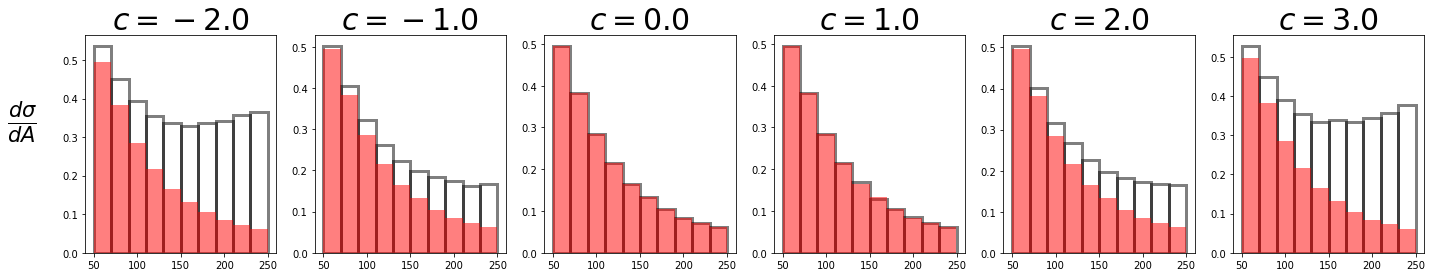

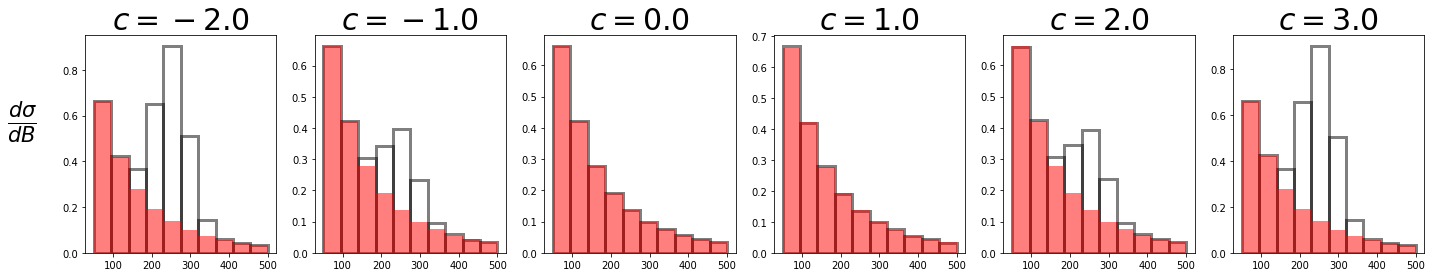

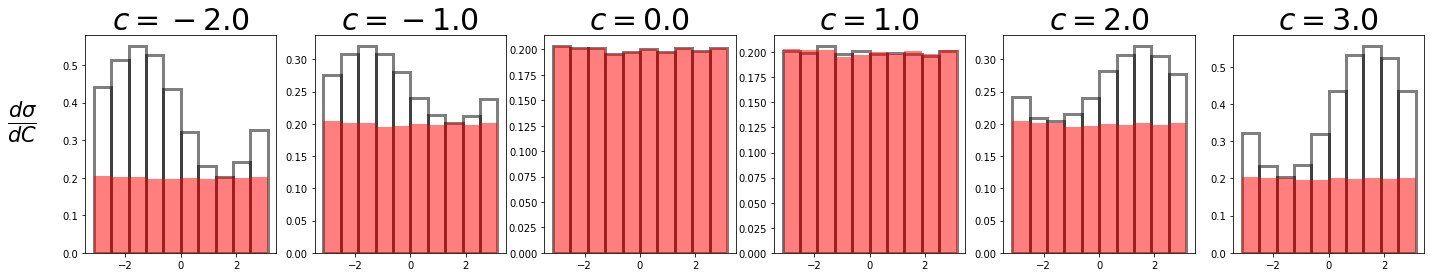

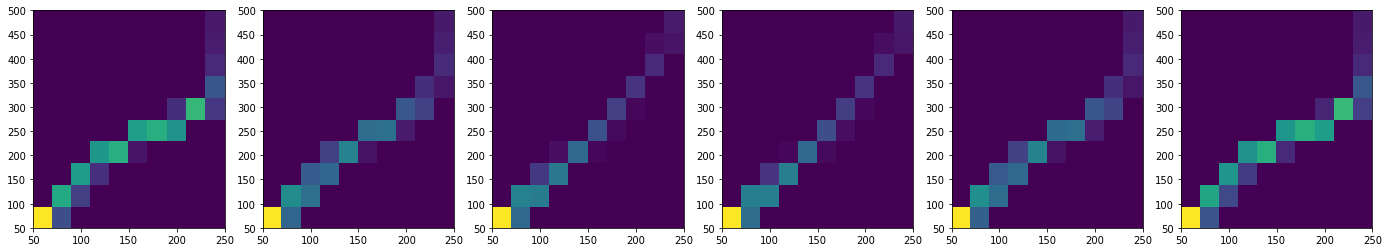

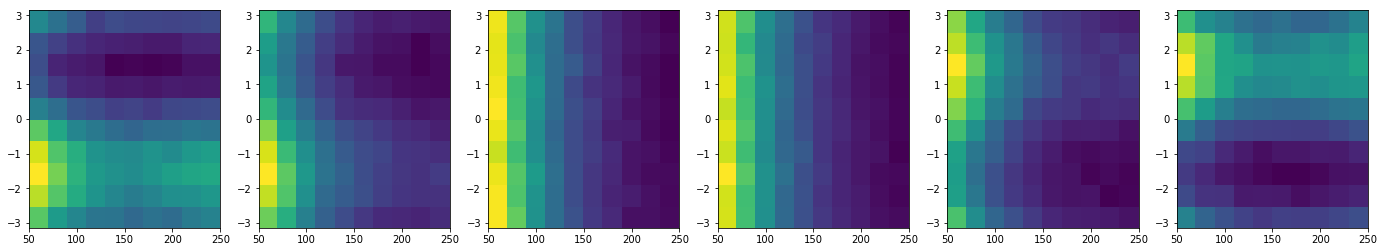

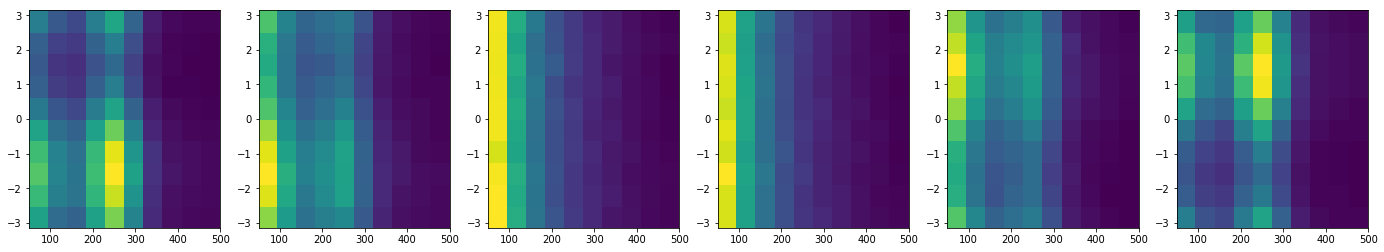

In [4]:
fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,0], alpha=0.5, weights=np.full(shape=dataset   [:,0].shape, fill_value=xsec   /n_gen_points), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,0], alpha=0.5, weights=np.full(shape=dataset_SM[:,0].shape, fill_value=xsec_SM/n_gen_points), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dA}$", fontsize=30, rotation=0, labelpad=40)
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,1], alpha=0.5, weights=np.full(shape=dataset   [:,1].shape, fill_value=xsec   /n_gen_points), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,1], alpha=0.5, weights=np.full(shape=dataset_SM[:,1].shape, fill_value=xsec_SM/n_gen_points), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dB}$", fontsize=30, rotation=0, labelpad=40)
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    xsec    = plot_xsections [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist(dataset   [:,2], alpha=0.5, weights=np.full(shape=dataset   [:,2].shape, fill_value=xsec   /n_gen_points), fill=False, edgecolor="k", linestyle="-" , linewidth=3)
    ax1.hist(dataset_SM[:,2], alpha=0.5, weights=np.full(shape=dataset_SM[:,2].shape, fill_value=xsec_SM/n_gen_points), fill=True , color    ="r", linestyle="-" , linewidth=3)
    ax1.set_title(f"$c = {plot_point}$", fontsize=30)
    if ax_idx > 0 : continue
    ax1.set_ylabel(r"$\frac{d\sigma}{dC}$", fontsize=30, rotation=0, labelpad=40)
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,0], dataset[:,1])
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,0], dataset[:,2])
plt.show()

fig = plt.figure(figsize=(4*n_plot_points,4))
for ax_idx, plot_point in enumerate(plot_points) :
    dataset = plot_datasets  [plot_point]
    ax1 = fig.add_subplot(1, n_plot_points, ax_idx+1)
    ax1.hist2d(dataset[:,1], dataset[:,2])
plt.show()


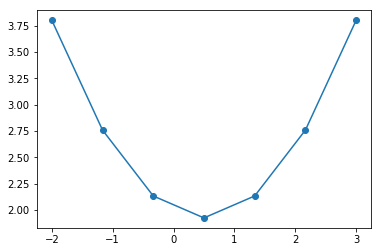

In [5]:
x = np.linspace(mu_range[0], mu_range[1], xsec_scan_points)
y = {}
for xp in x :
    model.set_param_value("c", xp)
    y[xp], _ = model.generate(0)
plt.plot(x, [y[xp] for xp in x], "o-")
plt.show()

In [6]:
def noise_model1 (self, x, *argv, **kwargs) :
    if hasattr(self, "return_value") == False :
        A_lims = [50, 250]
        B_lims = [50, 500]
        C_lims = [-1.*np.pi, np.pi]
        A_range = A_lims[1] - A_lims[0]
        B_range = B_lims[1] - B_lims[0]
        C_range = C_lims[1] - C_lims[0]
        self.return_value = 1. / (A_range*B_range*C_range)
    return self.return_value

def noise_model2 (self, x, *argv, **kwargs) :
    if hasattr(self, "return_value") == False :
        B_lims = [50, 500]
        C_lims = [-1.*np.pi, np.pi]
        B_range = B_lims[1] - B_lims[0]
        C_range = C_lims[1] - C_lims[0]
        self.return_value = 1. / (B_range*C_range)
    return self.return_value * stats.norm.pdf(x[0], 150, 50)

class NoiseModel :
    def clear (self) :
        self.name  = ""
        self.model = None
    def evaluate (self, x) :
        if type(self.model) == type(None) :
            raise RuntimeError(f"Cannot evaluate PDF - no function set")
        return self.model(self, x)
    @classmethod
    def from_noise_and_model (cls, noise, disc, new_name="") :
        def new_model (self, x, *argv, **kwargs) :
            f = noise.evaluate(x)
            D = disc.predict(np.array([x]))[0,0]
            return D * f / (1.-D)
        return cls(new_name, new_model)
    def __init__ (self, name="", model=None) :
        self.clear()
        self.name  = name
        self.model = model
        
NoiseModel1 = NoiseModel("NoiseModel1", noise_model1)
NoiseModel2 = NoiseModel("NoiseModel2", noise_model2)

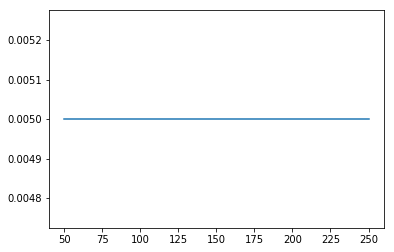

In [7]:
y = []
A_range = 200.
B_range = 450.
C_range = 2.*np.pi
n_points_A = 40
n_points_B = 40
n_points_C = 40
spacing_A  = A_range / (n_points_A)
spacing_B  = B_range / (n_points_B)
spacing_C  = C_range / (n_points_C)
samples_A = np.linspace(50, 250, n_points_A)
samples_B = np.linspace(50, 500, n_points_B)
samples_C = np.linspace(-1.*np.pi, np.pi, n_points_C)
for A in samples_A :
    yp = 0.
    for B in samples_B :
        for C in samples_C :
            yp = yp + NoiseModel1.evaluate([A,B,C]) * (spacing_B*spacing_C)
    y.append(yp)
plt.plot(samples_A, y)
plt.show()


In [8]:
noise_simulator = SamplingSimulator(name="noise_generator", 
                              model=NoiseModel1, 
                              axes=[samples_A, samples_B, samples_C])

noise_datapoints = noise_simulator.generate(n_train_points_per_c_per_ds)

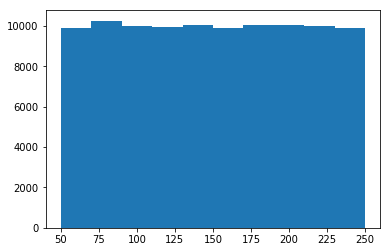

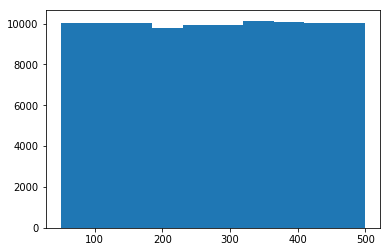

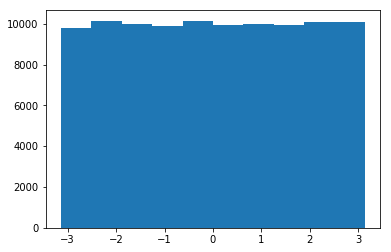

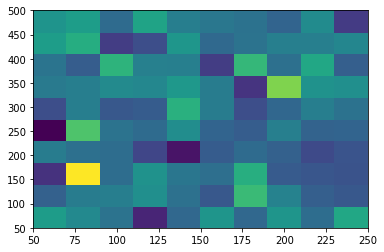

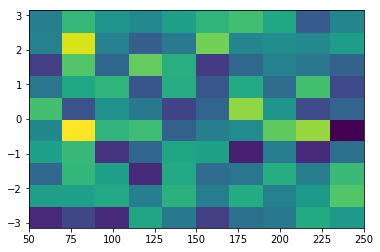

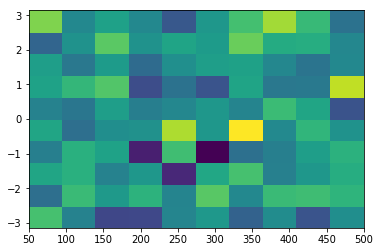

In [9]:

plt.hist(noise_datapoints[:,0])
plt.show()

plt.hist(noise_datapoints[:,1])
plt.show()

plt.hist(noise_datapoints[:,2])
plt.show()

plt.hist2d(noise_datapoints[:,0], noise_datapoints[:,1])
plt.show()

plt.hist2d(noise_datapoints[:,0], noise_datapoints[:,2])
plt.show()

plt.hist2d(noise_datapoints[:,1], noise_datapoints[:,2])
plt.show()

In [10]:
def shuffle (*v) :
    pairs = [_ for _ in zip(*v)]
    np.random.shuffle(pairs)
    to_ret = []
    for idx in range(len(v)) :
        to_ret.append(np.array([p[idx] for p in pairs]))
    return tuple(to_ret)

In [11]:
from keras.callbacks import EarlyStopping

In [12]:
train_DS_fake = noise_datapoints[np.random.randint(0, noise_datapoints.shape[0], n_train_points_per_c_per_ds),:]
train_DS_true = learn_datapoints[np.random.randint(0, learn_datapoints.shape[0], n_train_points_per_c_per_ds),:]

labels_true = np.array([1. for i in range(n_train_points_per_c_per_ds)])
labels_fake = np.array([0. for i in range(n_train_points_per_c_per_ds)])

train_data   = np.concatenate([train_DS_true, train_DS_fake])
train_labels = np.concatenate([labels_true  , labels_fake  ])

train_data, train_labels = shuffle(train_data, train_labels)


In [13]:
disc = models.create_unconditional_discriminator (dropout=0.1,
                                                  num_categories  = 1,
                                                  num_observables = 3,
                                                  batch_norm      = False,
                                                  mid_layers      = (30,30))

history = disc.fit(train_data, 
         train_labels,
         validation_split = 0.5,
         callbacks = [EarlyStopping(patience=10, restore_best_weights=True)],
         epochs=1000,
         shuffle=True,
         batch_size=20000)

Creating discriminator with 3 observables and 1 conditions
Instructions for updating:
Colocations handled automatically by placer.
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                120       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30)               

100000/100000 [==============================] - 0s 1us/step - loss: 0.2859 - val_loss: 0.2654
Epoch 58/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2849 - val_loss: 0.2630
Epoch 59/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2838 - val_loss: 0.2623
Epoch 60/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2821 - val_loss: 0.2610
Epoch 61/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2807 - val_loss: 0.2604
Epoch 62/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2806 - val_loss: 0.2600
Epoch 63/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2781 - val_loss: 0.2585
Epoch 64/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2769 - val_loss: 0.2575
Epoch 65/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2752 - val_loss: 0.2572
Epoch 66/1000
100000/100000 [====

Epoch 132/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2429 - val_loss: 0.2326
Epoch 133/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2429 - val_loss: 0.2312
Epoch 134/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2418 - val_loss: 0.2310
Epoch 135/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2425 - val_loss: 0.2306
Epoch 136/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2413 - val_loss: 0.2305
Epoch 137/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2413 - val_loss: 0.2299
Epoch 138/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2406 - val_loss: 0.2305
Epoch 139/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2428 - val_loss: 0.2292
Epoch 140/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2408 - val_loss: 0.2284
Epoch 141/

100000/100000 [==============================] - 0s 1us/step - loss: 0.2056 - val_loss: 0.1902
Epoch 207/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2061 - val_loss: 0.1886
Epoch 208/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2049 - val_loss: 0.1894
Epoch 209/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2032 - val_loss: 0.1896
Epoch 210/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2054 - val_loss: 0.1897
Epoch 211/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2051 - val_loss: 0.1877
Epoch 212/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2039 - val_loss: 0.1870
Epoch 213/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2042 - val_loss: 0.1881
Epoch 214/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.2020 - val_loss: 0.1861
Epoch 215/1000
100000/100

100000/100000 [==============================] - 0s 1us/step - loss: 0.1905 - val_loss: 0.1759
Epoch 281/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1899 - val_loss: 0.1711
Epoch 282/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1895 - val_loss: 0.1712
Epoch 283/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1905 - val_loss: 0.1714
Epoch 284/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1896 - val_loss: 0.1763
Epoch 285/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1892 - val_loss: 0.1709
Epoch 286/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1883 - val_loss: 0.1717
Epoch 287/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1872 - val_loss: 0.1701
Epoch 288/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1879 - val_loss: 0.1707
Epoch 289/1000
100000/100

100000/100000 [==============================] - 0s 1us/step - loss: 0.1776 - val_loss: 0.1625
Epoch 355/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1790 - val_loss: 0.1591
Epoch 356/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1788 - val_loss: 0.1585
Epoch 357/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1771 - val_loss: 0.1606
Epoch 358/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1770 - val_loss: 0.1603
Epoch 359/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1782 - val_loss: 0.1586
Epoch 360/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1784 - val_loss: 0.1594
Epoch 361/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1787 - val_loss: 0.1615
Epoch 362/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1779 - val_loss: 0.1576
Epoch 363/1000
100000/100

100000/100000 [==============================] - 0s 1us/step - loss: 0.1702 - val_loss: 0.1485
Epoch 429/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1723 - val_loss: 0.1527
Epoch 430/1000
100000/100000 [==============================] - 0s 1us/step - loss: 0.1716 - val_loss: 0.1502
Epoch 431/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1718 - val_loss: 0.1512
Epoch 432/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1699 - val_loss: 0.1508
Epoch 433/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1710 - val_loss: 0.1547
Epoch 434/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1701 - val_loss: 0.1478
Epoch 435/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1723 - val_loss: 0.1487
Epoch 436/1000
100000/100000 [==============================] - 0s 2us/step - loss: 0.1704 - val_loss: 0.1508
Epoch 437/1000
100000/100

In [14]:
constrastive_model = NoiseModel.from_noise_and_model(NoiseModel1, disc, "constrastive_model")

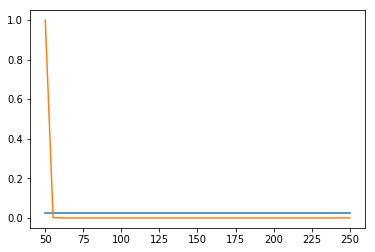

In [15]:
x = samples_A
y2 = []
for A in x :
    yp = 0.
    yp = yp + constrastive_model.evaluate([A,50.,0.]) * (spacing_B*spacing_C)
    y2.append(yp)
plt.plot(x, y/np.sum(y))
plt.plot(x, y2/np.sum(y2))
plt.show()

In [16]:
#  Brief:  use NoiseModel or ContrastiveModel to generate weights for pre-existing datapoints
#
def generate_weights (x, model1, model2) :
    weights = []
    for xp in x :
        weights.append(model2.evaluate(xp) / model1.evaluate(xp))
    return weights, x

noise_weights2, noise_datapoints2 = generate_weights(noise_simulator.generate(n_train_points_per_c_per_ds), 
                                                     NoiseModel1, 
                                                     constrastive_model)

noise_weights2 = noise_weights2 / np.sum(noise_weights2)

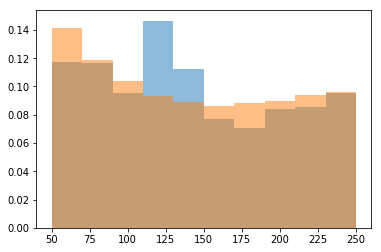

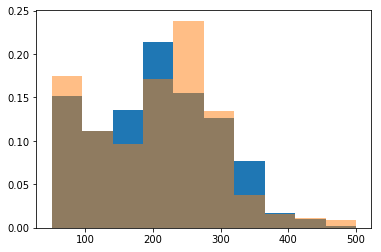

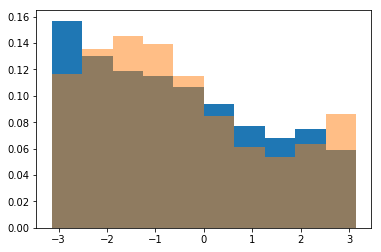

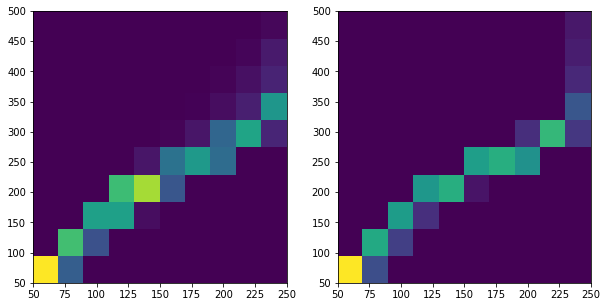

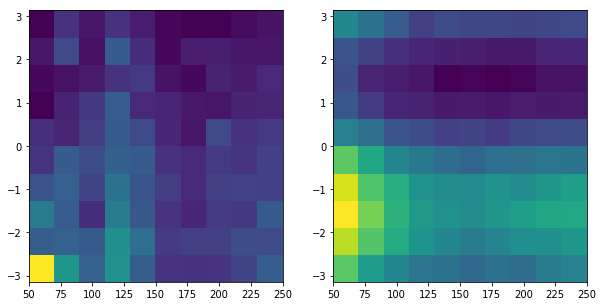

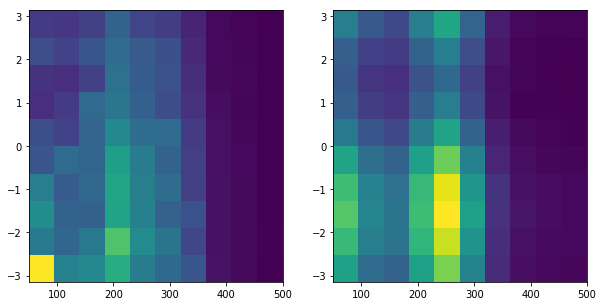

In [17]:
plt.hist(noise_datapoints2[:,0], alpha=0.5, weights=noise_weights2)
plt.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights )
plt.show()

plt.hist(noise_datapoints2[:,1], weights=noise_weights2)
plt.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights )
plt.show()

plt.hist(noise_datapoints2[:,2], weights=noise_weights2)
plt.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights )
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,1], weights=noise_weights2)
ax = fig.add_subplot(122)
ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,1], weights=learn_weights )
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,2], weights=noise_weights2)
ax = fig.add_subplot(122)
ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,2], weights=learn_weights )
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax.hist2d(noise_datapoints2[:,1], noise_datapoints2[:,2], weights=noise_weights2)
ax = fig.add_subplot(122)
ax.hist2d(learn_datapoints [:,1], learn_datapoints [:,2], weights=learn_weights )
plt.show()

In [23]:
random_indices     = np.random.randint(0, learn_datapoints .shape[0], n_train_points_per_c_per_ds)
train_DS_true2     = learn_datapoints  [random_indices,:]
train_weights_true = learn_weights     [random_indices]
train_weights_true = train_weights_true / np.sum(train_weights_true)

random_indices     = np.random.randint(0, noise_datapoints2.shape[0], n_train_points_per_c_per_ds)
train_DS_fake2     = noise_datapoints2 [random_indices,:]
train_weights_fake = learn_weights     [random_indices]
train_weights_fake = train_weights_fake / np.sum(train_weights_true)

train_data2    = np.concatenate([train_DS_true2    , train_DS_fake2    ])
train_labels2  = np.concatenate([labels_true       , labels_fake       ])
train_weights2 = np.concatenate([train_weights_true, train_weights_fake])
train_data2, train_labels2, train_weights2 = shuffle(train_data2, train_labels2, train_weights2)


In [24]:
disc2 = models.create_unconditional_discriminator (dropout=0.1,
                                                  num_observables = 3,
                                                  batch_norm      = True,
                                                  mid_layers      = (60,60,60))

history = disc2.fit(train_data2, 
                    train_labels2,
                    sample_weight=train_weights2,
                    validation_split = 0.5,
                    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)],
                    epochs=1000,
                    shuffle=True,
                    batch_size=20000,)

Creating discriminator with 3 observables and None conditions
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                240       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 60)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 60)                240       
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 60)                3660      
_________________________________________________________

100000/100000 [==============================] - 0s 4us/step - loss: 2.9851e-06 - val_loss: 2.8101e-06
Epoch 52/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9425e-06 - val_loss: 2.7865e-06
Epoch 53/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9472e-06 - val_loss: 2.7779e-06
Epoch 54/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9393e-06 - val_loss: 2.7630e-06
Epoch 55/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9269e-06 - val_loss: 2.7433e-06
Epoch 56/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9189e-06 - val_loss: 2.7282e-06
Epoch 57/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.9033e-06 - val_loss: 2.7187e-06
Epoch 58/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.8967e-06 - val_loss: 2.6949e-06
Epoch 59/1000
100000/100000 [==============================] - 0s 5us/step - l

Epoch 121/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.4956e-06 - val_loss: 2.3222e-06
Epoch 122/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4889e-06 - val_loss: 2.3055e-06
Epoch 123/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4916e-06 - val_loss: 2.3093e-06
Epoch 124/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4760e-06 - val_loss: 2.3241e-06
Epoch 125/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4719e-06 - val_loss: 2.3122e-06
Epoch 126/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4835e-06 - val_loss: 2.3029e-06
Epoch 127/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4741e-06 - val_loss: 2.3107e-06
Epoch 128/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.4720e-06 - val_loss: 2.2588e-06
Epoch 129/1000
100000/100000 [==========================

100000/100000 [==============================] - 0s 4us/step - loss: 2.2748e-06 - val_loss: 2.0169e-06
Epoch 191/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.2736e-06 - val_loss: 1.9943e-06
Epoch 192/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.2755e-06 - val_loss: 2.0114e-06
Epoch 193/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.2674e-06 - val_loss: 1.9974e-06
Epoch 194/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.2599e-06 - val_loss: 2.0083e-06
Epoch 195/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.2594e-06 - val_loss: 2.0026e-06
Epoch 196/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.2570e-06 - val_loss: 2.0048e-06
Epoch 197/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.2522e-06 - val_loss: 1.9694e-06
Epoch 198/1000
100000/100000 [==============================] - 0s 4us/

100000/100000 [==============================] - 1s 5us/step - loss: 2.1166e-06 - val_loss: 1.8129e-06
Epoch 260/1000
100000/100000 [==============================] - 1s 6us/step - loss: 2.1017e-06 - val_loss: 1.8086e-06
Epoch 261/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.1124e-06 - val_loss: 1.8142e-06
Epoch 262/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.1016e-06 - val_loss: 1.8194e-06
Epoch 263/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.1026e-06 - val_loss: 1.8338e-06
Epoch 264/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.1001e-06 - val_loss: 1.8298e-06
Epoch 265/1000
100000/100000 [==============================] - 0s 5us/step - loss: 2.1024e-06 - val_loss: 1.8057e-06
Epoch 266/1000
100000/100000 [==============================] - 0s 4us/step - loss: 2.0871e-06 - val_loss: 1.7979e-06
Epoch 267/1000
100000/100000 [==============================] - 0s 4us/

100000/100000 [==============================] - 1s 5us/step - loss: 1.9724e-06 - val_loss: 1.6672e-06
Epoch 329/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9620e-06 - val_loss: 1.6787e-06
Epoch 330/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9701e-06 - val_loss: 1.6661e-06
Epoch 331/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9864e-06 - val_loss: 1.6684e-06
Epoch 332/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9567e-06 - val_loss: 1.6690e-06
Epoch 333/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9544e-06 - val_loss: 1.6614e-06
Epoch 334/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9700e-06 - val_loss: 1.6636e-06
Epoch 335/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.9660e-06 - val_loss: 1.6630e-06
Epoch 336/1000
100000/100000 [==============================] - 0s 5us/

100000/100000 [==============================] - 1s 5us/step - loss: 1.8647e-06 - val_loss: 1.5650e-06
Epoch 398/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.8771e-06 - val_loss: 1.5629e-06
Epoch 399/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.8813e-06 - val_loss: 1.5543e-06
Epoch 400/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.8686e-06 - val_loss: 1.5646e-06
Epoch 401/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.8793e-06 - val_loss: 1.5555e-06
Epoch 402/1000
100000/100000 [==============================] - 0s 5us/step - loss: 1.8784e-06 - val_loss: 1.5567e-06
Epoch 403/1000
100000/100000 [==============================] - 1s 5us/step - loss: 1.8721e-06 - val_loss: 1.5489e-06
Epoch 404/1000
100000/100000 [==============================] - 1s 5us/step - loss: 1.8653e-06 - val_loss: 1.5491e-06
Epoch 405/1000
100000/100000 [==============================] - 1s 5us/

100000/100000 [==============================] - 0s 4us/step - loss: 1.7902e-06 - val_loss: 1.4730e-06
Epoch 467/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.7929e-06 - val_loss: 1.4747e-06
Epoch 468/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.8032e-06 - val_loss: 1.4728e-06
Epoch 469/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.8005e-06 - val_loss: 1.4791e-06
Epoch 470/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.8075e-06 - val_loss: 1.4720e-06
Epoch 471/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.8035e-06 - val_loss: 1.4600e-06
Epoch 472/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.7896e-06 - val_loss: 1.4741e-06
Epoch 473/1000
100000/100000 [==============================] - 0s 4us/step - loss: 1.7881e-06 - val_loss: 1.4727e-06
Epoch 474/1000
100000/100000 [==============================] - 0s 4us/

In [25]:
constrastive_model2 = NoiseModel.from_noise_and_model(constrastive_model, disc2, "constrastive_model2")

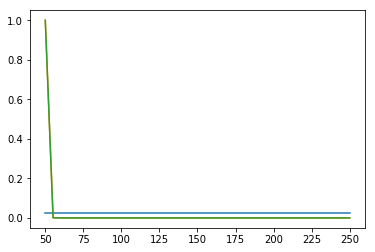

In [26]:
x = samples_A
y3 = []
for A in x :
    yp = 0.
    yp = yp + constrastive_model2.evaluate([A,50.,0.]) * (spacing_B*spacing_C)
    y3.append(yp)
plt.plot(x, y /np.sum(y ))
plt.plot(x, y2/np.sum(y2))
plt.plot(x, y3/np.sum(y3))
plt.show()

In [27]:
def generate_weights (x, model1, model2) :
    weights = []
    for xp in x :
        w = model2.evaluate(xp) / model1.evaluate(xp)
        if np.isnan(w) : w = 0.
        if np.isinf(w) : w = 1.
        weights.append(w)
    return weights, x

noise_weights3, noise_datapoints3 = generate_weights(noise_simulator.generate(n_train_points_per_c_per_ds), 
                                                     constrastive_model, 
                                                     constrastive_model2)

noise_weights3 = noise_weights3 / np.sum(noise_weights3)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [28]:
print(noise_weights3)

[0.00000000e+00 1.62678812e-08 8.70687095e-05 ... 3.87957742e-10
 0.00000000e+00 0.00000000e+00]


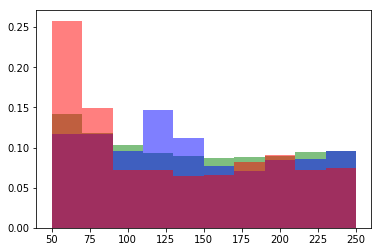

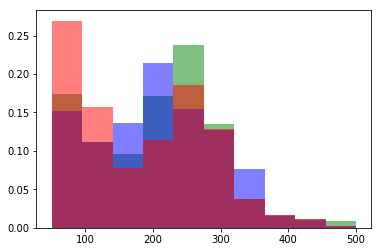

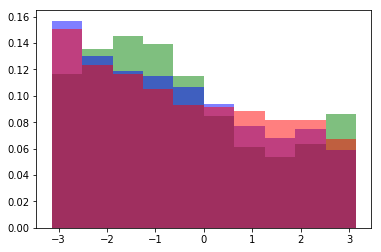

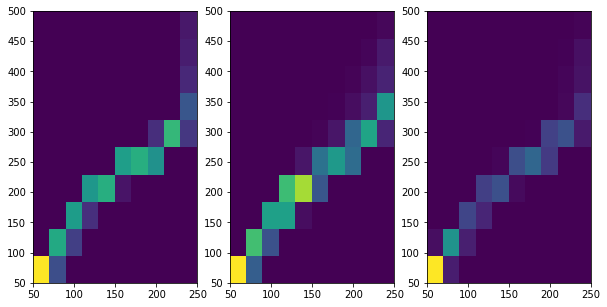

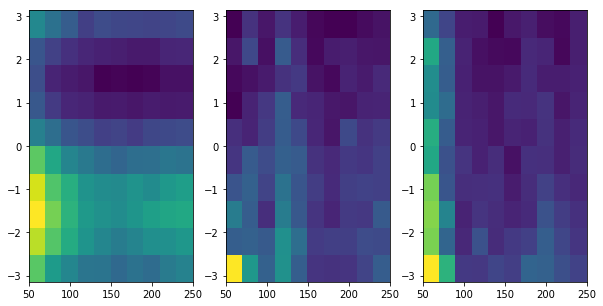

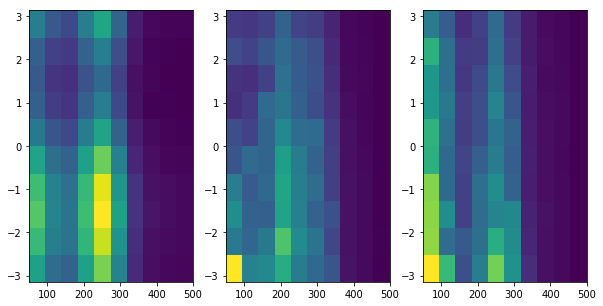

In [29]:

plt.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="g")
plt.hist(noise_datapoints2[:,0], alpha=0.5, weights=noise_weights2, color="b")
plt.hist(noise_datapoints3[:,0], alpha=0.5, weights=noise_weights3, color="r")
plt.show()

plt.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="g")
plt.hist(noise_datapoints2[:,1], alpha=0.5, weights=noise_weights2, color="b")
plt.hist(noise_datapoints3[:,1], alpha=0.5, weights=noise_weights3, color="r")
plt.show()

plt.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="g")
plt.hist(noise_datapoints2[:,2], alpha=0.5, weights=noise_weights2, color="b")
plt.hist(noise_datapoints3[:,2], alpha=0.5, weights=noise_weights3, color="r")
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131)
ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,1], weights=learn_weights )
ax = fig.add_subplot(132)
ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,1], weights=noise_weights2)
ax = fig.add_subplot(133)
ax.hist2d(noise_datapoints3[:,0], noise_datapoints3[:,1], weights=noise_weights3)
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131)
ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,2], weights=learn_weights )
ax = fig.add_subplot(132)
ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,2], weights=noise_weights2)
ax = fig.add_subplot(133)
ax.hist2d(noise_datapoints3[:,0], noise_datapoints3[:,2], weights=noise_weights3)
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(131)
ax.hist2d(learn_datapoints [:,1], learn_datapoints [:,2], weights=learn_weights )
ax = fig.add_subplot(132)
ax.hist2d(noise_datapoints2[:,1], noise_datapoints2[:,2], weights=noise_weights2)
ax = fig.add_subplot(133)
ax.hist2d(noise_datapoints3[:,1], noise_datapoints3[:,2], weights=noise_weights3)
plt.show()

In [30]:
def plot_result () :
    
    num_panels = 4
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints [:,0], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints2[:,0], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist(learn_datapoints [:,0], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints3[:,0], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
    
    fname = "figures/test_SCE_withSampling/dist_A.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints [:,1], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints2[:,1], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist(learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints3[:,1], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
        
    fname = "figures/test_SCE_withSampling/dist_B.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints [:,2], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints2[:,2], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist(learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.hist(noise_datapoints3[:,2], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
        
    fname = "figures/test_SCE_withSampling/dist_C.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,1], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist2d(noise_datapoints [:,0], noise_datapoints [:,1], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,1], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist2d(noise_datapoints3[:,0], noise_datapoints3[:,1], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
        
    fname = "figures/test_SCE_withSampling/dist_AB.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist2d(learn_datapoints [:,0], learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist2d(noise_datapoints [:,0], noise_datapoints [:,2], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist2d(noise_datapoints2[:,0], noise_datapoints2[:,2], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist2d(noise_datapoints3[:,0], noise_datapoints3[:,2], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
        
    fname = "figures/test_SCE_withSampling/dist_AC.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()
    
    fig = plt.figure(figsize=(5*num_panels, 5))
    
    ax = fig.add_subplot(1, num_panels, 1)
    ax.hist2d(learn_datapoints [:,1], learn_datapoints [:,2], alpha=0.5, weights=learn_weights , color="k")
    ax.set_title("Simulated data", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 2)
    ax.hist2d(noise_datapoints [:,1], noise_datapoints [:,2], alpha=0.5, weights=np.full(shape=(len(noise_datapoints),), fill_value=1.0/len(noise_datapoints)), color="b")
    ax.set_title("Initial noise", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 3)
    ax.hist2d(noise_datapoints2[:,1], noise_datapoints2[:,2], alpha=0.5, weights=noise_weights2, color="r")
    ax.set_title("NCE", fontsize=15)
    
    ax = fig.add_subplot(1, num_panels, 4)
    ax.hist2d(noise_datapoints3[:,1], noise_datapoints3[:,2], alpha=0.5, weights=noise_weights3, color="r")
    ax.set_title("SCE (iteration 1)", fontsize=15)
        
    fname = "figures/test_SCE_withSampling/dist_BC.pdf"
    make_sure_dir_exists_for_filename(fname)
    plt.savefig(fname, bbox_inches="tight")
    plt.show()

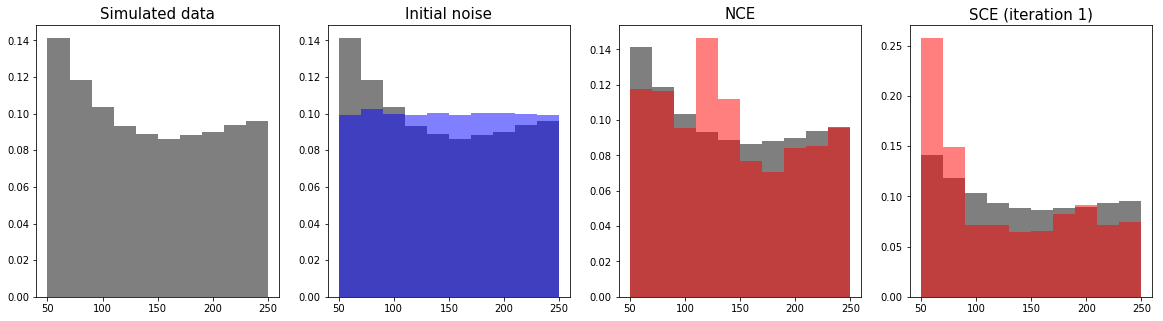

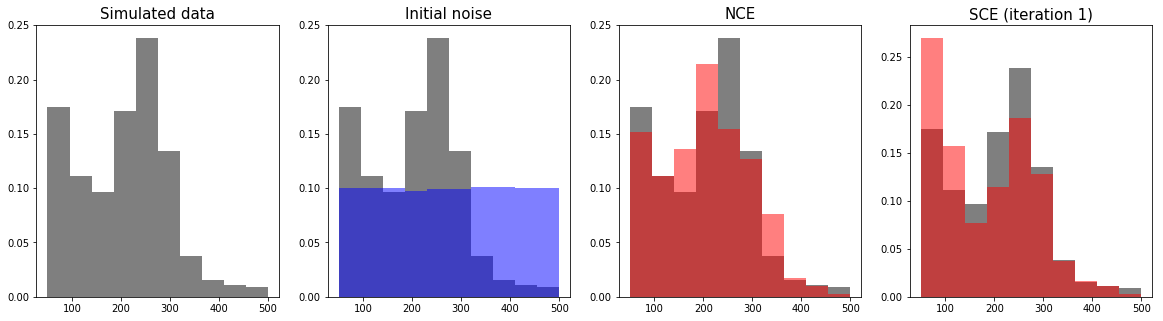

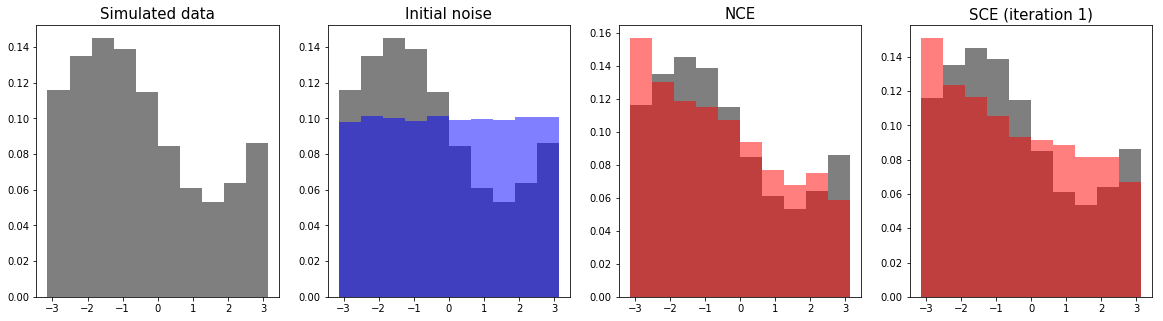

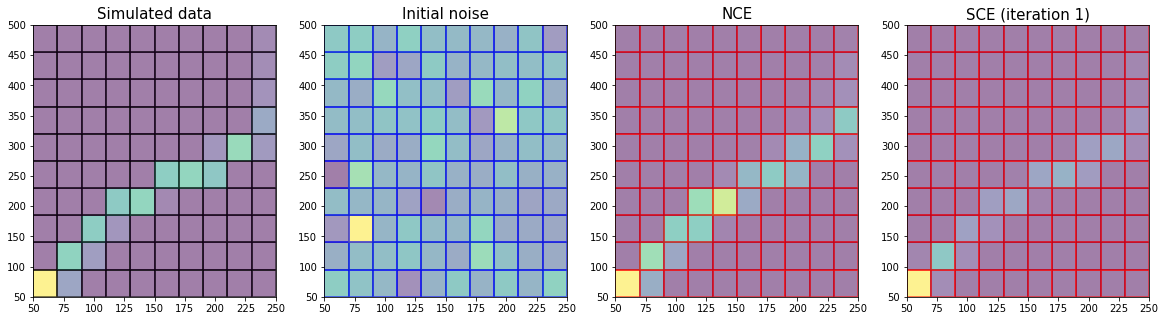

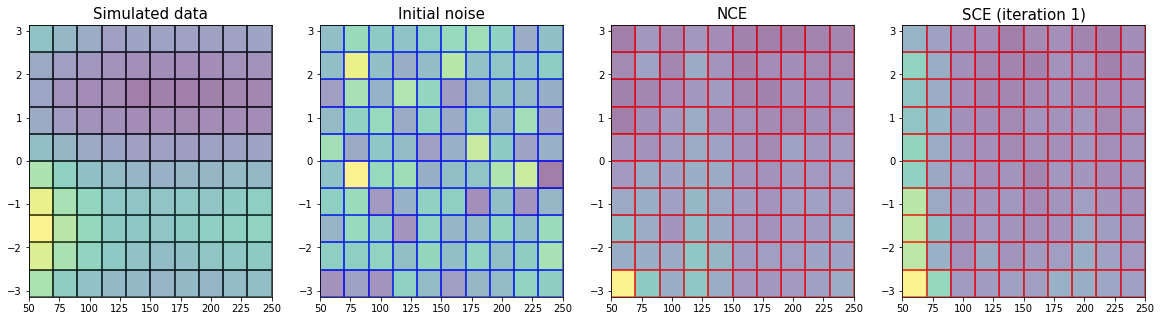

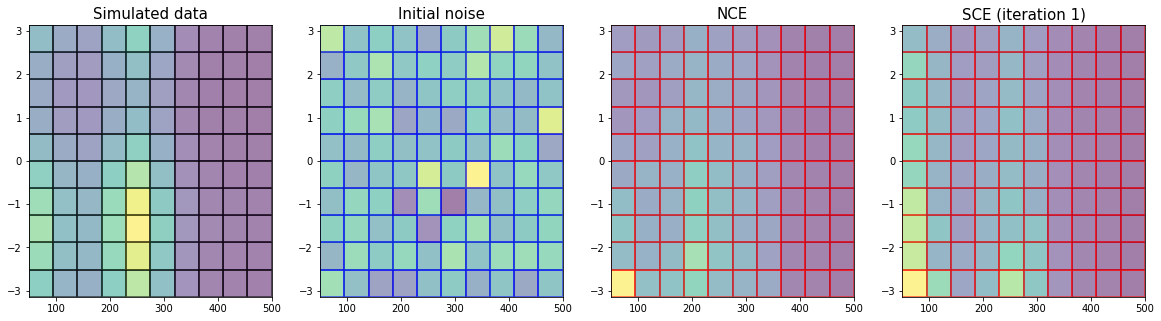

In [31]:
plot_result()